In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import scipy.constants as cte

In [20]:
class espectro:
    
    # inicialización
    def __init__(self, canales, cuentas, z, muestra):
        # ponemos todos los datos en arrays y calculamos sus respectivos errores
        
        self.muestra = muestra
        self.cuentas = np.array(cuentas)
        self.canales = np.array(canales)
        self.energia = np.array([]) # en eV?
        self.z = np.array([z[2*i] for i in range(int(len(z)/2))])
        
        self.err_cuentas = np.array([0.25 + np.sqrt(abs(N)) for N in self.cuentas])
        self.err_canales = np.array([0.5 for ch in self.canales])
        self.err_energia = np.array([]) # en eV?
        self.errz = np.array([z[2*i+1] for i in range(int(len(z)/2))])


    # gráfico del espectro
    def plot(self, log=False, errs=False, ch=False):
        fig = plt.figure(figsize=(10,6))

        if ch:
            x = self.canales
            xerr = self.err_canales
            plt.xlabel('Canales', fontsize = 13)
        else:
            x = self.energia
            xerr = self.err_energia
            plt.xlabel('Energía (eV)', fontsize = 13)
        
        if errs:
            plt.errorbar(x, self.cuentas, fmt='.', xerr=xerr, yerr=self.err_cuentas, label="Observaciones", zorder=0)
        else:
            plt.plot(x, self.cuentas, '.', label="Observaciones", zorder=0)

        plt.ylabel('Cuentas', fontsize = 13)
        plt.title("Espectro {}".format(self.muestra))
        plt.legend()
        plt.grid()
        
        if log:
            plt.yscale('log')
            
        return fig

    # gráfico del ajuste
    def plot_fit(self):
        print("plot_fit")


    # selección del rango para ajustar
    def select_range(self,fit_range,ch=False):
        if ch:
            b = self.canales
        else:
            b = self.energia
        c = b[b<fit_range[0]]
        d = b[b<=fit_range[1]]
    
        min_index = len(c)
        max_index = len(d)
        return min_index, max_index


    # ajuste
    def fit(self, func, beta_init, ch=False, pprint=False, use_err = False, hay_extra_args=False, n=1, sigma=0, hay_lb=True, def_fit_range=False, fit_range=[], group=-1):
        # función general de ajuste con ODR con cualquier modelo con
        # restricciones en qué sección ajustar
        
        # agrego los argumentos adicionales si los hubiera
        if hay_extra_args:
            if sigma==0:
                model = Model(func, extra_args=[n])
            else:
                model = Model(func, extra_args=[n,sigma])
        else:
            model = Model(func)
        
        # selecciono el rango en el cual ajustar
        if def_fit_range:
            min_index, max_index = self.select_range(fit_range,ch)
        else:
            min_index, max_index = 0, len(self.canales)

        if ch:
            x_fit = self.canales[min_index:max_index]
        else:
            x_fit = self.energia[min_index:max_index]
        y_fit = self.cuentas[min_index:max_index]
        
        # defino los datos con o sin errores
        if use_err:
            if ch:
                err_x_fit = self.err_canales[min_index:max_index]
            else:
                err_x_fit = self.err_energia[min_index:max_index]
            err_y_fit = self.err_cuentas[min_index:max_index]
            data_fit= RealData(x_fit, y_fit,sx=err_x_fit, sy=err_y_fit)
        else:
            data_fit= RealData(x_fit, y_fit)
        
        # ajusto y guardo los parámetros relevantes
        odr_fit = ODR(data_fit, model, beta0=beta_init)
        out = odr_fit.run()
        params = np.array(out.beta)
        err_params = np.array(out.sd_beta)
        chi_red_dof = out.res_var  # ODR ya usa esto como estimador de chi_red_dof
        
        # imprimo en pantalla los datos relevantes: por defecto de ODR o convolución
        if pprint:
            out.pprint()
        else:
            print("rango de ajuste: ",fit_range)
            print("parámetros iniciales: ",beta_init,'\n')
            print("parámetros finales: ")
            for i in range(len(params)):
                print("p{}: {} +/- {}".format(i,params[i],err_params[i]))
                if i%group == group-1:
                    print("")
            print("chi2_red: {}".format(chi_red_dof),'\n')
            
        return params, err_params, chi_red_dof


    # calibración de canales a energía/long. de onda/frecuencia/etc.
    def calibrar(self, func, err_func, B, errB, hay_extra_args=False, extra_args=[]):
        if hay_extra_args:
            self.energia = func(extra_args[0],B,self.canales)
            self.err_energia = err_func(extra_args[0],extra_args[1],B,errB,self.canales,self.err_canales)
        else:
            self.energia = func(B,self.canales)
            self.err_energia = err_func(B,errB,self.canales,self.err_canales)

In [21]:
# carga de datos de las muestras a analizar
def load_file(file_name):
    data_file = open(file_name, "r")
    ch = []
    cuentas = []
    
    if ".ASC" in file_name:
        for line in data_file:
            if "," in line:
                c, cts, ROI = [float(x) for x in line.split(", ")]
                ch.append(c)
                cuentas.append(cts)
                # el ROI no lo guardo porque no lo uso en ningún lado
    else:
        for line in data_file:
            c, cts = [float(x.replace(",", ".")) for x in line.split("\t")]
            ch.append(c)
            cuentas.append(cts)
    data_file.close()
        
    return np.array(ch), np.array(cuentas)

In [34]:
# FUNCIONES

# recta
def recta_cal(B,x):
    return B[0] + B[1]*x

def err_recta_cal(B,errB,x,errx):
    return np.sqrt(errB[0]**2 + (x*errB[1])**2 + (B[1]*errx)**2)

# recta sin ordenada al origen
def prop_rel(B,x):
    return B*x

def err_prop_rel(B,errB,x,errx):
    return np.sqrt((x*errB)**2 + (B*errx)**2)

# calibración y pasaje de longitud de onda a energía en eV
def ch_to_energy(func,B,x):
    aux = func(B,x)
    return cte.physical_constants['Planck constant in eV/Hz'][0]*cte.c/(aux*1e-9)

def err_ch_to_energy(func,err_func,B,errB,x,errx):
    aux = func(B,x)
    erraux = err_func(B,errB,x,errx)
    return ch_to_energy(func,B,x)*np.abs(erraux/aux)

# Lambert-Beer
def alpha_values(I,I0,z):
    return np.log(I0/I)/z

def err_alpha_values(I,errI,I0,errI0,z,errz):
    return np.sqrt( (errI0/I0)**2 + (errI/I)**2 + (alpha_values(I,I0,z)*errz)**2 )/z

# (alfa*E)**2
def alpha_h_f_2(alpha,E):
    return (alpha*E)**2

def err_alpha_h_f_2(alpha,err_alpha,E,err_E):
    return 2*alpha_h_f_2(alpha,E)*np.sqrt((err_alpha/alpha)**2 + (err_E/E)**2)

# gaussiana
def gaussian(B,x):
    '''
    B[0] = amplitud
    B[1] = mu
    B[2] = sigma
    '''
    return B[0]*np.exp((-(x - B[1])**2)/(2*B[2]**2))

def gauss_n(B,x,n):
    """ 
    B[3*i] = amplitud
    B[3*i+1] = mu
    B[3*i+2] = sigma

    B[3*n] = línea de base
    """

    p = []
    f = []

    for i in range(n):
        p.append([B[3*i],B[3*i+1],B[3*i+2]])
        f.append(gaussian(p[i],x))
    
    return sum(f) + B[3*n]

rango de ajuste:  []
parámetros iniciales:  [10000, 241, 1, 100, 250, 3, 100, 285, 1, 100, 290, 1, 1800, 300, 1, 100, 305, 3, 100, 320, 1, 2000, 352, 1, 200, 357, 3, 3500, 393, 1, 100, 398, 3, 6000, 423, 1, 100, 428, 3, 1500, 495, 1, 100, 500, 3, 1500, 533, 1, 100, 538, 3, 100, 565, 1, 50] 

parámetros finales: 
p0: 10702.136158041109 +/- 1539.8451095122311
p1: 242.49627412488636 +/- 0.32365295154699986
p2: 1.8929701596224309 +/- 0.18305883080072383

p3: 217.43505966489823 +/- 33.67766757578311
p4: 249.403779288624 +/- 1.375433589540633
p5: 6.021930347912649 +/- 0.6906157772948591

p6: 257.1823442672973 +/- 29.97727078988951
p7: 283.8958422455023 +/- 0.6496690323893941
p8: 2.5182021627567734 +/- 0.45789833094918475

p9: 210.74070281267902 +/- 35.841960030595025
p10: 290.0811636471199 +/- 0.5908664801089101
p11: 1.6491597020502973 +/- 0.46410167219726134

p12: 1480.7917982459776 +/- 424.6788070565982
p13: 301.1554249545297 +/- 0.42406803797240294
p14: 1.2659720673613306 +/- 0.3479603054

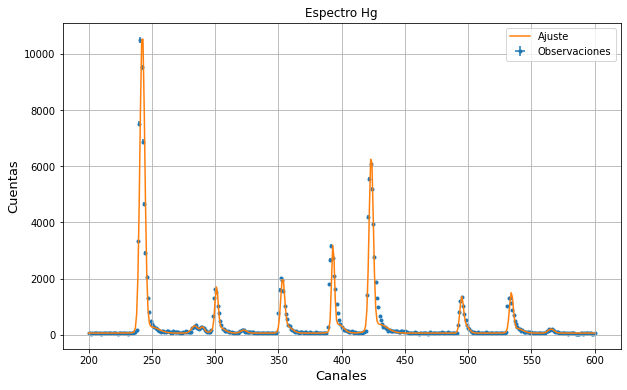

In [23]:
# Espectro de la lámpara de Hg

# tomo los datos del archivo y los cargo en un espectro
carpeta = "datos/calibracion_y_fondo/"
file_Hg = "Hg.txt"
canales_Hg, cuentas_Hg = load_file(carpeta+file_Hg)

# grafico
spec_Hg = espectro(canales_Hg, cuentas_Hg, [0,1], 'Hg')
fig_Hg = spec_Hg.plot(errs=True,ch=True,log=False)

# ajusto 18 gaussianas para los 6 picos relevantes
n = 18
beta_init_Hg = [
    10000, 241, 1,
    100, 250, 3,
    100, 285, 1,
    100, 290, 1,
    1800, 300, 1,
    100, 305, 3,
    100, 320, 1,
    2000, 352, 1,
    200, 357, 3,
    3500, 393, 1,
    100, 398, 3,
    6000, 423, 1,
    100, 428, 3,
    1500, 495, 1,
    100, 500, 3,
    1500, 533, 1,
    100, 538, 3,
    100, 565, 1,
    50
]
param_Hg, err_param_Hg, chi_redof_Hg = spec_Hg.fit(gauss_n, beta_init_Hg, ch=True, use_err=True, hay_extra_args=True, n=n, group=3)

# grafico
plt.plot(spec_Hg.canales, gauss_n(param_Hg, spec_Hg.canales, n), label="Ajuste")
plt.legend()
plt.show()

pico0: 242.49627412488636 +/- 0.32365295154699986  	->	253.6517
pico1: 301.1554249545297 +/- 0.42406803797240294  	->	296.728
pico2: 353.4361069244816 +/- 0.39471369471753753  	->	365.0153
pico3: 393.24929965261055 +/- 0.40560686829922904  	->	398.3931
pico4: 423.4225983421897 +/- 0.4044138627827916  	->	435.8328
pico5: 534.1990859767326 +/- 0.419103750105131  	->	546.0735

B0: -1.7335884835798965 +/- 10.790316914992797
B1: 0.9820240683924606 +/- 0.028168923300227376
chi2_red:  291.2995994357528


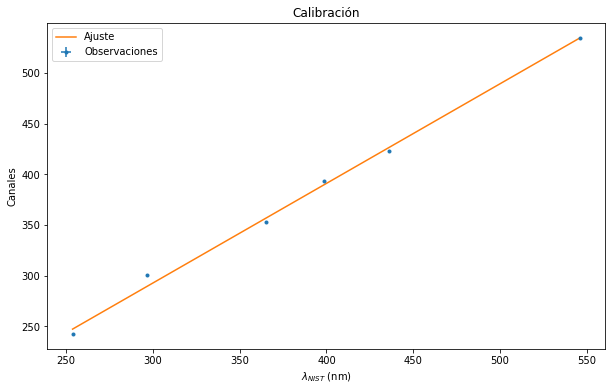

-------------------------------------------------------------------------------------
B: 0.9776443686146054 +/- 0.00636855358876392
chi2_red:  234.54357023532748


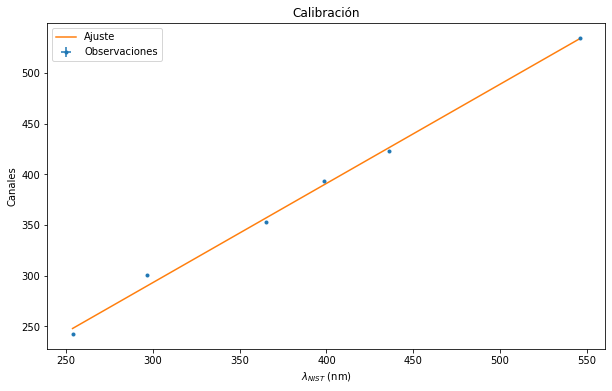

In [24]:
# CALIBRACIÓN usando el AJUSTE gaussiano para el Hg

# selecciono los picos relevantes
picos = []
err_picos = []
for i in range(3*n):
    if param_Hg[i]>1000 and i!=39:
        picos.append(param_Hg[i+1])
        err_picos.append(err_param_Hg[i+1])

# picos de referencia (NIST: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm)
picos_nist = np.array([253.6517, 296.7280, 365.0153, 398.3931, 435.8328, 546.0735])

for i in range(len(picos)):
    print("pico{}: {} +/- {}  \t->\t{}".format(i,picos[i],err_picos[i],picos_nist[i]))
print("")

# ajuste lineal
model_fit = Model(recta_cal)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[0,1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

for i in range(2):
    print("B{}: {} +/- {}".format(i,params_cal[i],err_params_cal[i]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, recta_cal(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

print("-------------------------------------------------------------------------------------")
# ajuste lineal proporcional
model_fit = Model(prop_rel)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

print("B: {} +/- {}".format(params_cal[0],err_params_cal[0]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, prop_rel(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

pico0: 241.0 +/- 0.5  	->	253.6517
pico1: 300.0 +/- 0.5  	->	296.728
pico2: 352.0 +/- 0.5  	->	365.0153
pico3: 392.0 +/- 0.5  	->	398.3931
pico4: 423.0 +/- 0.5  	->	435.8328
pico5: 532.5 +/- 0.5  	->	546.0735

B0: 0.8608425015476783 +/- 11.518740418230589
B1: 0.9737075872907704 +/- 0.02921856340919371
chi2_red:  184.81724087825035


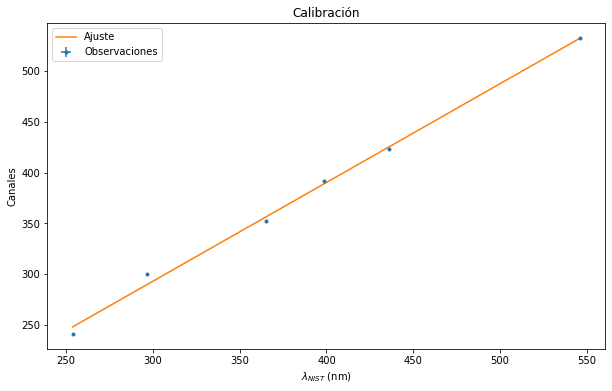

-------------------------------------------------------------------------------------
B: 0.9758269235451558 +/- 0.006300392651764278
chi2_red:  148.06000545474544


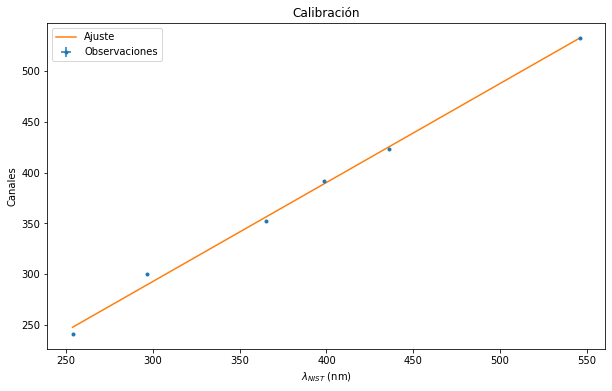

In [25]:
# CALIBRACIÓN usando los MÁXIMOS para el Hg

# busco a mano los picos relevantes
picos = np.array([241, 300, 352, 392, 423, 532.5])
err_picos = np.array([0.5 for i in range(6)])

# picos de referencia (NIST: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm)
picos_nist = np.array([253.6517, 296.7280, 365.0153, 398.3931, 435.8328, 546.0735])

for i in range(len(picos)):
    print("pico{}: {} +/- {}  \t->\t{}".format(i,picos[i],err_picos[i],picos_nist[i]))
print("")

# ajuste lineal
model_fit = Model(recta_cal)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[0,1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

for i in range(2):
    print("B{}: {} +/- {}".format(i,params_cal[i],err_params_cal[i]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, recta_cal(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

print("-------------------------------------------------------------------------------------")
# ajuste lineal proporcional
model_fit = Model(prop_rel)
data_fit= RealData(picos_nist, picos,sx=1e-4, sy=err_picos)

odr_fit = ODR(data_fit, model_fit, beta0=[1])
out = odr_fit.run()

params_cal = np.array(out.beta)
err_params_cal = np.array(out.sd_beta)
chi_red_dof_cal = out.res_var

print("B: {} +/- {}".format(params_cal[0],err_params_cal[0]))
print("chi2_red: ",chi_red_dof_cal)

# grafico
fig_cal = plt.figure(figsize=(10,6))
plt.title("Calibración")

plt.errorbar(picos_nist, picos, xerr=1e-4, yerr=err_picos, label='Observaciones', fmt='.')
x = np.linspace(picos_nist[0],picos_nist[5])
plt.plot(x, prop_rel(params_cal,x), label='Ajuste')

plt.xlabel(r'$\lambda_{NIST}$ (nm)')
plt.ylabel('Canales')
plt.legend()
plt.show()

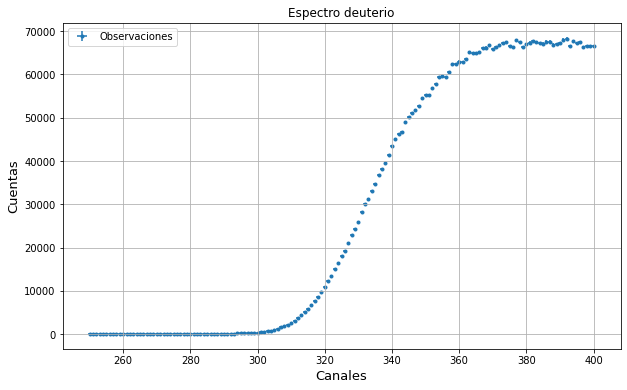

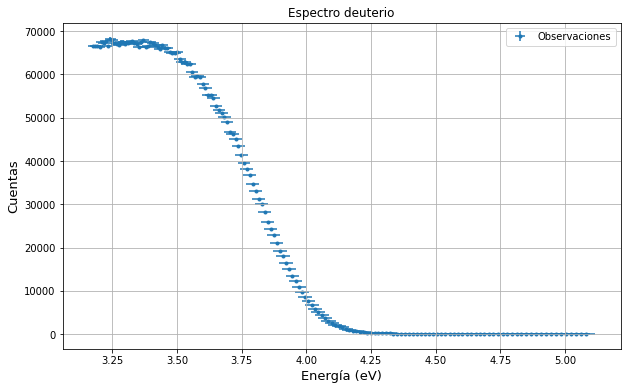

In [26]:
# FONDO usando una lámpara de deuterio

# tomo los datos del archivo y los cargo en un espectro
carpeta = "datos/calibracion_y_fondo/"
file_fondo = "deuterio.txt"
canales_fondo, cuentas_fondo = load_file(carpeta+file_fondo)

# grafico para ver cómo son
spec_fondo = espectro(canales_fondo, cuentas_fondo, [0,1], 'deuterio')
spec_fondo.plot(errs=True,ch=True)
plt.show()

spec_fondo.calibrar(ch_to_energy, err_ch_to_energy, params_cal, err_params_cal, hay_extra_args=True, extra_args=[prop_rel,err_prop_rel])
spec_fondo.plot(errs=True)
plt.show()

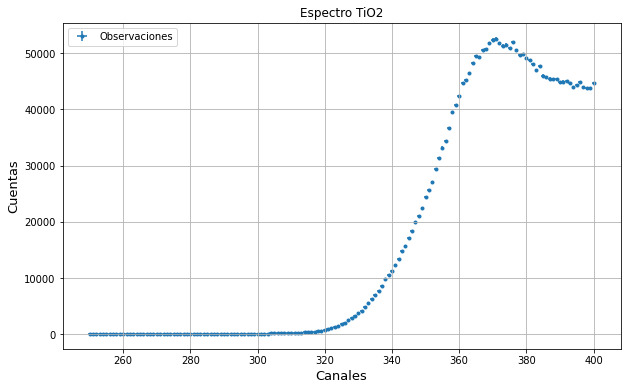

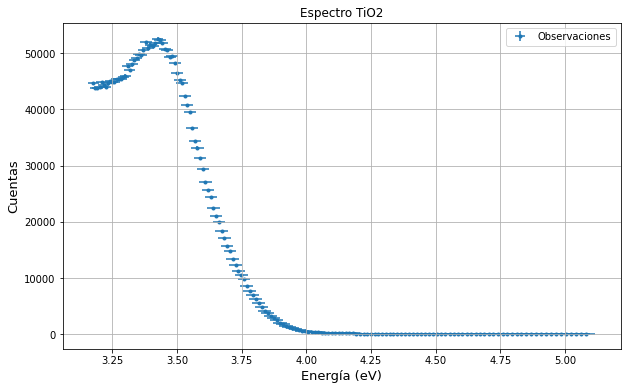

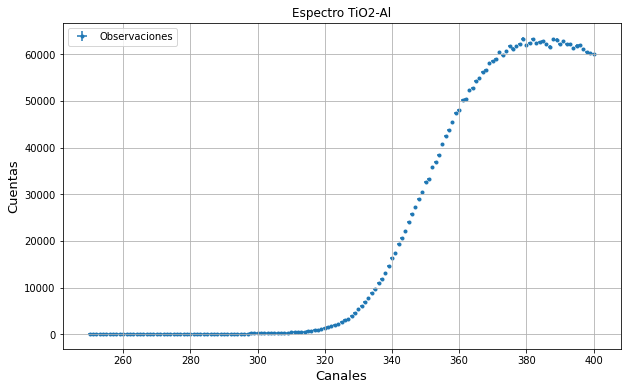

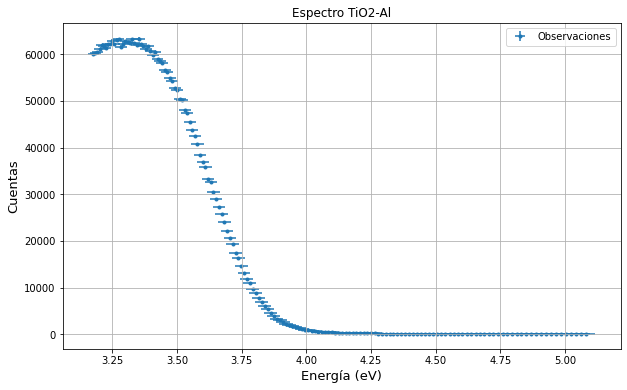

In [27]:
# espectros de las muestras y calibración

# los nombres
carpeta = "datos/"
file_names = ['TiO2.txt','TiO2-Al.txt']

specs = {}
zetas = {
    # [ztot,errztot,z0,errz0,z1,errz1...]
    'TiO2': [200e-9, 1e-9],
    'TiO2-Al': [260e-9, np.sqrt(2)*1e-9, 200e-9, 1e-9, 60e-9, 1e-9]
}

for file_name in file_names:
    # tomo los datos
    nombre_muestra = file_name.split(".")[0]
    ch_spec, cuentas_spec = load_file(carpeta+file_name)
    
    # construyo el espectro
    specs[nombre_muestra] = espectro(ch_spec, cuentas_spec, zetas[nombre_muestra], nombre_muestra)
    specs[nombre_muestra].plot(errs=True,ch=True)
    plt.show()

    # calibro y transformo de canales a energía
    specs[nombre_muestra].calibrar(ch_to_energy, err_ch_to_energy, params_cal, err_params_cal, hay_extra_args=True, extra_args=[prop_rel,err_prop_rel])
    fig_spec = specs[nombre_muestra].plot(errs=True)
    plt.show()

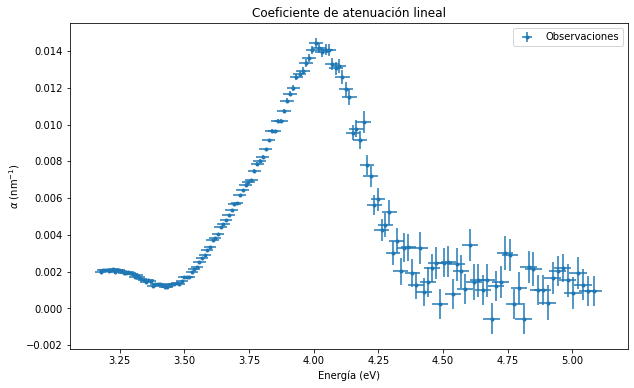

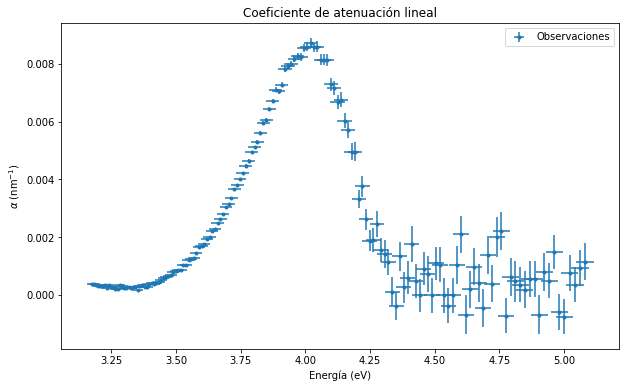

In [31]:
# Coeficiente de atenuación lineal
alphas = {}
err_alphas = {}

for muestra in specs:
    # calculo el coeficiente de atenuación lineal
    alphas[muestra] = alpha_values(specs[muestra].cuentas,spec_fondo.cuentas,specs[muestra].z[0])
    err_alphas[muestra] = err_alpha_values(specs[muestra].cuentas,specs[muestra].err_cuentas,spec_fondo.cuentas,spec_fondo.err_cuentas,specs[muestra].z[0],specs[muestra].errz[0])

    # grafico
    fig = plt.figure(figsize=(10,6))
    plt.errorbar(specs[muestra].energia, alphas[muestra]*1e-9, xerr=specs[muestra].err_energia, yerr=err_alphas[muestra]*1e-9, label='Observaciones', fmt='.')
    plt.title('Coeficiente de atenuación lineal')
    plt.xlabel('Energía (eV)')
    plt.ylabel(r'$\alpha$ (nm$^{-1}$)')
    plt.legend()
    plt.show

<ipython-input-34-49f7ae849008>:40: RuntimeWarning: divide by zero encountered in true_divide
  return 2*alpha_h_f_2(alpha,E)*np.sqrt((err_alpha/alpha)**2 + (err_E/E)**2)
<ipython-input-34-49f7ae849008>:40: RuntimeWarning: invalid value encountered in multiply
  return 2*alpha_h_f_2(alpha,E)*np.sqrt((err_alpha/alpha)**2 + (err_E/E)**2)


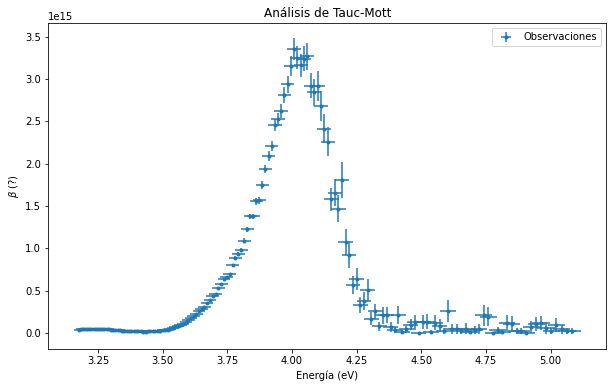

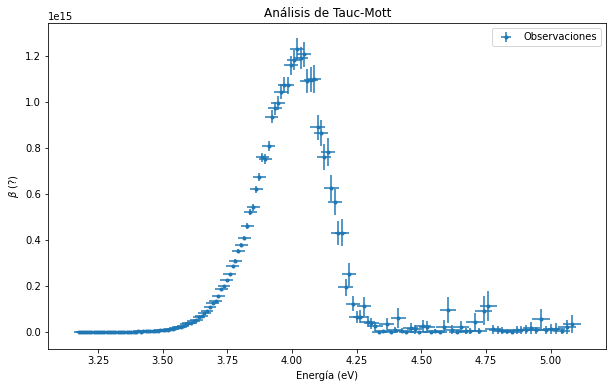

In [35]:
# Análisis de Tauc-Mott con n = 1/2
beta = {}
err_beta = {}

for muestra in specs:
    # calculo beta = (alfa*E)**2
    beta[muestra] = alpha_h_f_2(alphas[muestra], specs[muestra].energia)
    err_beta[muestra] = err_alpha_h_f_2(alphas[muestra], err_alphas[muestra], specs[muestra].energia, specs[muestra].err_energia)

    # grafico
    fig = plt.figure(figsize=(10,6))
    plt.errorbar(specs[muestra].energia, beta[muestra], xerr=specs[muestra].err_energia, yerr=err_beta[muestra],label='Observaciones', fmt='.')
    plt.title('Análisis de Tauc-Mott')
    plt.xlabel('Energía (eV)')
    plt.ylabel(r'$\beta$ (?)')
    plt.legend()
    plt.show